In [ ]:
# %pip install torch==2.7

In [1]:
import os

import pandas as pd
import numpy as np

import torch
from torch import nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T

from transformers import ConvNextModel

from PIL import Image

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-05-18 10:28:45.718026: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 10:28:51.784849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 10:29:09.766966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu124
True


In [3]:
import transformers
print(transformers.__version__)
print(transformers.utils.is_torch_available())

4.52.0.dev0
True


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
true_negatives_dir = '/home/jupyter/datasphere/datasets/sasgis-dataset-100k/google_satellite_data/negative_samples'
true_positives_dir = '/home/jupyter/datasphere/datasets/sasgis-dataset-100k/google_satellite_data/positive_samples'
# gen_positives_dir = '/home/jupyter/datasphere/datasets/midjourney_generated_positives/midjourney_generated_positives'

In [19]:
true_anomaly_indices = [
    0, 4, 9, 10, 11, 14, 15, 16, 17, 21, 26, 27, 30, 32, 33, 35, 37,
    40, 48, 49, 53, 58, 59, 62, 65, 68, 69, 72, 75, 76,
    80, 88, 89, 91, 98, 99, 101, 102, 105, 108, 113, 114, 116,
    128, 131, 136, 139, 141, 161
]

GS_DIR = '/home/jupyter/datasphere/datasets/sasgis-dataset-100k/google_satellite_data'


GS_POSITIVE_PATHS = sorted([
    f'{GS_DIR}/positive_samples/{s}'
    for s in os.listdir(f'{GS_DIR}/positive_samples') 
    if s.endswith('.jpeg')
])

GS_DEFINITE_POSITIVE_PATHS = sorted([
    f'{GS_DIR}/positive_samples/{s}'
    for s in os.listdir(f'{GS_DIR}/positive_samples') 
    if s.endswith('.jpeg')
    and int(s.split('.')[0]) in true_anomaly_indices
])

# GS_DEFINITE_POSITIVE_COORDS = [
#     (lat, lon) 
#     for i, (iid, _, _, lon, lat, _, _, _, _, _, _, _) 
#     in pd.read_csv(f'{GS_DIR}/Eastern_desert_archaeological_structures_NEW.csv').iterrows()
#     if i in true_anomaly_indices
# ]

len(GS_POSITIVE_PATHS), len(GS_DEFINITE_POSITIVE_PATHS)

(165, 49)

In [20]:
(len(os.listdir(true_negatives_dir)),
     len(os.listdir(true_positives_dir)))

(99255, 166)

In [21]:
class ChosenPositivesDataset(Dataset):
    
    def __init__(self, true_negatives_dir, true_positives_filenames, transform=None):
        
        self.true_negatives_dir = true_negatives_dir
        self.true_negatives_filenames = [
            x for x in os.listdir(self.true_negatives_dir)
            if x.endswith('.jpeg')
        ]
        self.true_positives_filenames = true_positives_filenames
        
        self.n_true_negatives = len(self.true_negatives_filenames)
        self.n_true_positives = len(self.true_positives_filenames)
        
        np.random.seed(43)
        self.true_negatives_idxs = np.random.choice(
            range(self.n_true_negatives),
            size=self.n_true_positives,
            replace=False
        )
        
        self.transform = transform
        
    def __len__(self):
        return 2 * self.n_true_positives
    
    def __getitem__(self, idx):
        
        if idx < self.n_true_positives:
            file = os.path.join(self.true_negatives_dir, self.true_negatives_filenames[self.true_negatives_idxs[idx]])
            label = 0
        else:
            file = self.true_positives_filenames[idx - self.n_true_positives]
            label = 1        
        
        image = Image.open(file)
        if self.transform:
            image = self.transform(image)
        return image, label

In [22]:
transform = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
# индексы до 100 в трейн

train_dataset = ChosenPositivesDataset(true_negatives_dir, GS_POSITIVE_PATHS[: 100], transform=transform)
val1_dataset = ChosenPositivesDataset(true_negatives_dir, GS_POSITIVE_PATHS[100: ], transform=transform)
val2_dataset = ChosenPositivesDataset(true_negatives_dir, GS_DEFINITE_POSITIVE_PATHS[-13:], transform=transform)

len(train_dataset), len(val1_dataset), len(val2_dataset)

(200, 130, 26)

In [30]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

val1_loader = DataLoader(
    val1_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

val2_loader = DataLoader(
    val2_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

In [ ]:
# ConvNextModel.from_pretrained('facebook/convnext-tiny-224')

In [ ]:
# backbone: bs * 768 * 7 * 7

In [31]:
class ConvNextClassifier(nn.Module):
    
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        # self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Conv2d(768, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        hid_state = self.backbone(x)['last_hidden_state']
        return self.head(hid_state)

In [32]:
backbone = ConvNextModel.from_pretrained('facebook/convnext-tiny-224')
model = ConvNextClassifier(backbone=backbone)

In [ ]:
# batch = next(iter(val_loader))
# imgs, labels = batch
# print(f'{imgs.shape=} {labels.shape=}')

In [ ]:
# labels

In [ ]:
# with torch.no_grad():
    # outs = model(imgs)
# print(f'{outs.shape=}')

In [ ]:
# outs.mean()

In [36]:
criterion = nn.BCEWithLogitsLoss()

In [37]:
def evaluate(model, val_loader):
    model.to(device)
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == targets.int()).sum().item()
            total += targets.size(0)
    return {
        'bce_loss': total_loss / len(val_loader), 
        'accuracy': correct / total
    }

In [38]:
def train_model(model, train_loader, val_loader, epochs, freeze_backbone, optimizer):
    
    model.train()
    
    if freeze_backbone:
        for param in model.backbone.parameters():
            param.requires_grad = False
    else:
        for param in model.backbone.parameters():
            param.requires_grad = True
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()

        val_eval_dict = evaluate(model, val_loader)
        val_loss, val_accuracy = val_eval_dict['bce_loss'], val_eval_dict['accuracy']
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {running_loss/len(train_loader):.06f} - Val Loss: {val_loss:.06f} - Val Accuracy: {val_accuracy:.06f}')


In [39]:
print(f'before training:')
print(f'train: {evaluate(model, train_loader)}')
print(f'val1: {evaluate(model, val1_loader)}')
print(f'val2: {evaluate(model, val2_loader)}')

before training:
train: {'bce_loss': 0.6843748433249337, 'accuracy': 0.505}
val1: {'bce_loss': 0.6527228355407715, 'accuracy': 0.5230769230769231}
val2: {'bce_loss': 0.6957315802574158, 'accuracy': 0.5384615384615384}


In [40]:
backbone = ConvNextModel.from_pretrained('facebook/convnext-tiny-224')
model = ConvNextClassifier(backbone=backbone).to(device)

In [41]:
optimizer_head = torch.optim.AdamW(model.head.parameters(), lr=1e-9)
train_model(model, train_loader, val1_loader, epochs=10, freeze_backbone=True, optimizer=optimizer_head)

Epoch 1/10 - Train Loss: 0.733008 - Val Loss: 0.756388 - Val Accuracy: 0.453846
Epoch 2/10 - Train Loss: 0.721971 - Val Loss: 0.756380 - Val Accuracy: 0.453846
Epoch 3/10 - Train Loss: 0.726827 - Val Loss: 0.756373 - Val Accuracy: 0.453846
Epoch 4/10 - Train Loss: 0.717322 - Val Loss: 0.756366 - Val Accuracy: 0.453846
Epoch 5/10 - Train Loss: 0.720263 - Val Loss: 0.756360 - Val Accuracy: 0.453846
Epoch 6/10 - Train Loss: 0.710996 - Val Loss: 0.756354 - Val Accuracy: 0.453846
Epoch 7/10 - Train Loss: 0.717701 - Val Loss: 0.756347 - Val Accuracy: 0.453846
Epoch 8/10 - Train Loss: 0.702439 - Val Loss: 0.756341 - Val Accuracy: 0.453846
Epoch 9/10 - Train Loss: 0.717857 - Val Loss: 0.756336 - Val Accuracy: 0.453846
Epoch 10/10 - Train Loss: 0.717677 - Val Loss: 0.756331 - Val Accuracy: 0.453846


In [42]:
model.eval();
print('before unfreezing:')
print(f'train: {evaluate(model, train_loader)}')
print(f'val1: {evaluate(model, val1_loader)}')
print(f'val2: {evaluate(model, val2_loader)}')

before unfreezing:
train: {'bce_loss': 0.7160036734172276, 'accuracy': 0.49}
val1: {'bce_loss': 0.7563306450843811, 'accuracy': 0.45384615384615384}
val2: {'bce_loss': 0.7368417978286743, 'accuracy': 0.5384615384615384}


In [43]:
optimizer_fine_tune = torch.optim.AdamW(model.parameters(), lr=1e-11)
train_model(model, train_loader, val1_loader, epochs=10, freeze_backbone=False, optimizer=optimizer_fine_tune)

Epoch 1/10 - Train Loss: 0.731799 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 2/10 - Train Loss: 0.729191 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 3/10 - Train Loss: 0.730258 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 4/10 - Train Loss: 0.715096 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 5/10 - Train Loss: 0.717600 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 6/10 - Train Loss: 0.720584 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 7/10 - Train Loss: 0.730247 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 8/10 - Train Loss: 0.720116 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 9/10 - Train Loss: 0.720071 - Val Loss: 0.756331 - Val Accuracy: 0.453846
Epoch 10/10 - Train Loss: 0.709116 - Val Loss: 0.756331 - Val Accuracy: 0.453846


In [44]:
model.eval();
print('final scores:')
print(f'train: {evaluate(model, train_loader)}')
print(f'val1: {evaluate(model, val1_loader)}')
print(f'val2: {evaluate(model, val2_loader)}')

final scores:
train: {'bce_loss': 0.7237334847450256, 'accuracy': 0.49}
val1: {'bce_loss': 0.7563306331634522, 'accuracy': 0.45384615384615384}
val2: {'bce_loss': 0.7368417382240295, 'accuracy': 0.5384615384615384}


# Подсчет метрик

In [45]:
model.eval();

In [46]:
val1_outputs = np.array([])
val1_lables = np.array([])
for (imgs_batch, labels_batch) in val1_loader:
    imgs_batch = imgs_batch.to(device)
    output = model(imgs_batch).flatten().detach().cpu().numpy()
    val1_outputs = np.append(val1_outputs, output)
    val1_lables = np.append(val1_lables, labels_batch)

In [47]:
val2_outputs = np.array([])
val2_lables = np.array([])
for (imgs_batch, labels_batch) in val2_loader:
    imgs_batch = imgs_batch.to(device)
    output = model(imgs_batch).flatten().detach().cpu().numpy()
    val2_outputs = np.append(val2_outputs, output)
    val2_lables = np.append(val2_lables, labels_batch)

In [48]:
train_outputs = np.array([])
train_lables = np.array([])
for (imgs_batch, labels_batch) in train_loader:
    imgs_batch = imgs_batch.to(device)
    output = model(imgs_batch).flatten().detach().cpu().numpy()
    train_outputs = np.append(train_outputs, output)
    train_lables = np.append(train_lables, labels_batch)

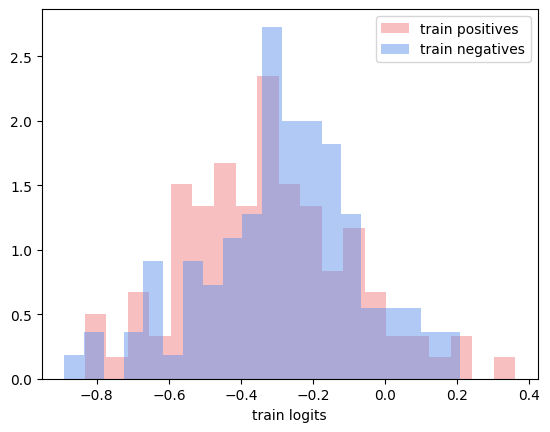

In [49]:
plt.hist(train_outputs[train_lables == 1], density=True, alpha=0.5, bins=20, color='lightcoral', label='train positives')
plt.hist(train_outputs[train_lables == 0], density=True, alpha=0.5, bins=20, color='cornflowerblue', label='train negatives')
plt.xlabel('train logits')
plt.legend()
plt.show()

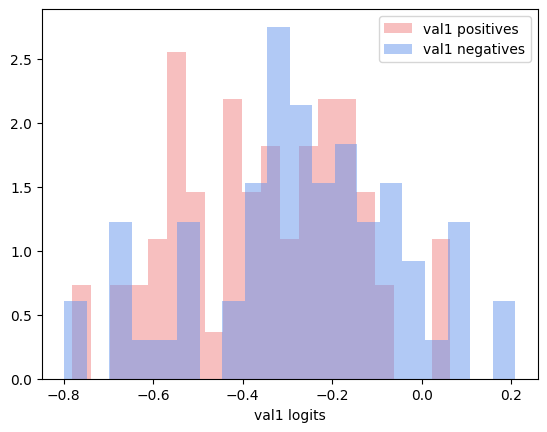

In [50]:
plt.hist(val1_outputs[val1_lables == 1], density=True, alpha=0.5, bins=20, color='lightcoral', label='val1 positives')
plt.hist(val1_outputs[val1_lables == 0], density=True, alpha=0.5, bins=20, color='cornflowerblue', label='val1 negatives')
plt.xlabel('val1 logits')
plt.legend()
plt.show()

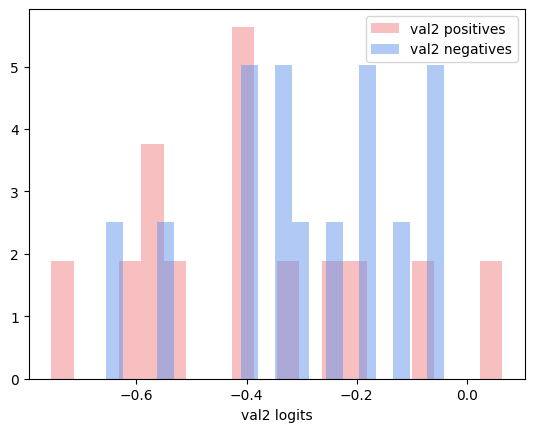

In [51]:
plt.hist(val2_outputs[val2_lables == 1], density=True, alpha=0.5, bins=20, color='lightcoral', label='val2 positives')
plt.hist(val2_outputs[val2_lables == 0], density=True, alpha=0.5, bins=20, color='cornflowerblue', label='val2 negatives')
plt.xlabel('val2 logits')
plt.legend()
plt.show()

In [52]:
precision_thresholds = np.array([0.80, 0.85, 0.90, 0.95])

In [53]:
val1_anomaly_scores_np = np.array(sorted(val1_outputs[val1_lables == 1]))
val1_negative_scores_np = np.array(sorted(val1_outputs[val1_lables == 0]))

val2_anomaly_scores_np = np.array(sorted(val2_outputs[val2_lables == 1]))
val2_negative_scores_np = np.array(sorted(val2_outputs[val2_lables == 0]))

In [54]:
thesholds = np.quantile(val1_anomaly_scores_np, 1 - precision_thresholds)
percent_disproved = np.array([
    np.mean(val1_negative_scores_np < threshold)
    for threshold in thesholds
])

# сколько процентов данных отбрасываются из рассмотрения для фиксированного порого точности

print('val1')
for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
    print(f'precision {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%')
    
    
# with open(f'{anomaly_scores_dir}/thresholds_anomalies.txt', 'w') as f:
#     for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
        # f.write(f'preci/sion {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%\n')

val1
precision 0.80 anomaly score threshold -0.55 result 12.31%
precision 0.85 anomaly score threshold -0.56 result 12.31%
precision 0.90 anomaly score threshold -0.60 result 10.77%
precision 0.95 anomaly score threshold -0.66 result 7.69%


In [55]:
thesholds = np.quantile(val2_anomaly_scores_np, 1 - precision_thresholds)
percent_disproved = np.array([
    np.mean(val2_negative_scores_np < threshold)
    for threshold in thesholds
])

# сколько процентов данных отбрасываются из рассмотрения для фиксированного порого точности

print('val2')
for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
    print(f'precision {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%')
    
    
# with open(f'{anomaly_scores_dir}/thresholds_anomalies.txt', 'w') as f:
#     for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
        # f.write(f'preci/sion {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%\n')

val2
precision 0.80 anomaly score threshold -0.56 result 7.69%
precision 0.85 anomaly score threshold -0.57 result 7.69%
precision 0.90 anomaly score threshold -0.59 result 7.69%
precision 0.95 anomaly score threshold -0.66 result 0.00%


# Отрисовка предсказаний

In [ ]:
def plot_prediction(indices, dataset_pil=val1_dataset_pil, dataset=val1_dataset):
    
    n = len(indices)
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(4 * n, 4))
    
    for ax_ind, img_ind in enumerate(indices):
        
        pil_img, _ = dataset_pil[img_ind]
        img, label = dataset[img_ind]
        img = img.reshape(1, 3, 224, 224).to(device)
        out = torch.sigmoid(model(img)).detach().cpu().numpy().item()
        
        axs[ax_ind].axis('off')
        axs[ax_ind].imshow(pil_img)
        axs[ax_ind].set_title(f'{out:.08f}')
        
    fig.tight_layout()
    fig.show()    

In [ ]:
plot_prediction([0, 1, 2, 3])